In [ ]:
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.15.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Install libraries first

Be sure  keras with tensorflow installed
`!conda install -c conda-forge keras`


In [ ]:
!pip install git+https://github.com/qubvel/resnet34
!pip install git+https://github.com/qubvel/efficientnet
!pip install git+https://github.com/qubvel/classification_models.git
!pip install git+https://github.com/qubvel/segmentation_models
!pip install -U git+https://github.com/albu/albumentations
!pip install tta-wrapper

## Defining data generator

In [ ]:
from keras.utils import Sequence
from skimage.io import imread
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np

tf.logging.set_verbosity(tf.logging.ERROR)
%load_ext autoreload
%autoreload 2
%matplotlib inline
from albumentations import (Blur, Compose, HorizontalFlip, HueSaturationValue,
                            IAAEmboss, IAASharpen, JpegCompression, OneOf,
                            RandomBrightness, RandomBrightnessContrast,
                            RandomContrast, RandomCrop, RandomGamma,
                            RandomRotate90, RGBShift, ShiftScaleRotate,
                            Transpose, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion)
 
import albumentations as albu
from albumentations import Resize

class DataGeneratorFolder(Sequence):
    def __init__(self, root_dir=r'/content/drive/My Drive/new/', image_folder='img/', mask_folder='masks/', 
                 batch_size=1, image_size=768, nb_y_features=1, 
                 augmentation=None,
                 suffle=True):
        self.image_filenames = os.listdir(os.path.join(root_dir, image_folder))
        self.mask_names = os.listdir(os.path.join(root_dir, mask_folder))
        self.batch_size = batch_size
        self.currentIndex = 0
        self.augmentation = augmentation
        self.image_size = image_size
        self.nb_y_features = nb_y_features
        self.indexes = None
        self.suffle = suffle
        self.root = root_dir
        self.img = image_folder
        self.mask = mask_folder
        
    def __len__(self):
        """
        Calculates size of batch
        """
        return int(np.ceil(len(self.image_filenames) / (self.batch_size)))

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.suffle==True:
            self.image_filenames, self.mask_names = shuffle(self.image_filenames, self.mask_names)
        
    def read_image_mask(self, image_name, mask_name):
        image_name = self.root + self.img + image_name
        mask_name = self.root + self.mask + mask_name
        return imread(image_name)/255, (imread(mask_name, as_gray=True) > 0).astype(np.int8)

    def __getitem__(self, index):
        """
        Generate one batch of data
        
        """
        # Generate indexes of the batch
        data_index_min = int(index*self.batch_size)
        data_index_max = int(min((index+1)*self.batch_size, len(self.image_filenames)))
        
        indexes = self.image_filenames[data_index_min:data_index_max]

        this_batch_size = len(indexes) # The last batch can be smaller than the others
        
        # Defining dataset
        X = np.empty((this_batch_size, self.image_size, self.image_size, 3), dtype=np.float32)
        y = np.empty((this_batch_size, self.image_size, self.image_size, self.nb_y_features), dtype=np.uint8)

        for i, sample_index in enumerate(indexes):

            X_sample, y_sample = self.read_image_mask(self.image_filenames[index * self.batch_size + i], 
                                                    self.mask_names[index * self.batch_size + i])
                 
            # if augmentation is defined, we assume its a train set
            if self.augmentation is not None:
                # print("shit")
                # Augmentation code
                augmented = self.augmentation(self.image_size)(image=X_sample, mask=y_sample)
                image_augm = augmented['image']
                mask_augm = augmented['mask'].reshape(self.image_size, self.image_size, self.nb_y_features)
                X[i, ...] = np.clip(image_augm, a_min = 0, a_max=1)
                y[i, ...] = mask_augm
                # print("fuck")
            # if augmentation isnt defined, we assume its a test set. 
            # Because test images can have different sizes we resize it to be divisable by 32
            elif self.augmentation is None and self.batch_size ==1:
                X_sample, y_sample = self.read_image_mask(self.image_filenames[index * 1 + i], 
                                                      self.mask_names[index * 1 + i])
                augmented = Resize(height=(X_sample.shape[0]//32)*32, width=(X_sample.shape[1]//32)*32)(image = X_sample, mask = y_sample)
                X_sample, y_sample = augmented['image'], augmented['mask']

                return X_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], 3).astype(np.float32),\
                       y_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], self.nb_y_features).astype(np.uint8)

        return X, y

## Data augmentation - albumentations

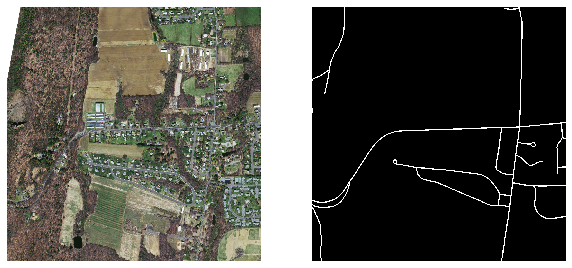

In [2]:
def aug_with_crop(image_size = 256, crop_prob = 1):
    return Compose([
        RandomCrop(width = image_size, height = image_size, p=crop_prob),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
        Transpose(p=0.5),
        ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        RandomBrightnessContrast(p=0.5),
        RandomGamma(p=0.25),
        IAAEmboss(p=0.25),
        Blur(p=0.01, blur_limit = 3),
        OneOf([
            ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            GridDistortion(p=0.5),
            OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8)
    ], p = 1)

tmp_generator = DataGeneratorFolder(root_dir = '/content/drive/My Drive/new/',
                                     image_folder = 'input/', 
                                     mask_folder = 'output/',
                                     batch_size = 1,
                                     nb_y_features = 1)
plt.figure(figsize=(10, 5))
Xtest, ytest = tmp_generator.__getitem__(1)
plt.subplot(121)
plt.imshow(Xtest[0])     
plt.axis('off')
plt.subplot(122)
plt.imshow(ytest[0, :,:,0], 'gray')
plt.axis('off');

In [ ]:
# setting generators
test_generator = DataGeneratorFolder(root_dir = '/content/drive/My Drive/new/', 
                           image_folder = 'input_test/', 
                           mask_folder = 'output_test/', 
                                   batch_size=1,
                                   nb_y_features = 1, suffle = True)

train_generator = DataGeneratorFolder(root_dir = '/content/drive/My Drive/new/', 
                                      image_folder = 'input/', 
                                      mask_folder = 'output/', 
                                      batch_size=1,
                                      # image_size=512,
                                      nb_y_features = 1, suffle = True)

In [ ]:
# !python /content/drive/My\ Drive/new/get.py

## Callbacks

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown= 10,
                               patience=10,verbose =1,
                               min_lr=0.1e-5)
mode_autosave = ModelCheckpoint("./weights/road_crop.resnet34.h5",monitor='val_iou_score', 
                                   mode = 'max', save_best_only=True, verbose=1, period =10)

# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=10, verbose=1, mode = 'auto') 

# tensorboard for monitoring logs
tensorboard = TensorBoard(log_dir='./logs/tenboard', histogram_freq=0,
                          write_graph=True, write_images=False)

callbacks = [mode_autosave, lr_reducer, tensorboard, early_stopping]

In [ ]:
from segmentation_models import Unet
from keras.optimizers import Adam
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss
from segmentation_models.metrics import iou_score

def plot_training_history(history):
    """
    Plots model training history 
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["iou_score"], label="Train iou")
    ax_acc.plot(history.epoch, history.history["val_iou_score"], label="Validation iou")
    ax_acc.legend()
    
model = Unet(backbone_name = 'resnet34', encoder_weights='imagenet', encoder_freeze = True)
model.compile(optimizer = Adam(),
                    loss=bce_jaccard_loss, metrics=[iou_score])

history = model.fit_generator(train_generator, shuffle =True,
                  epochs=15, workers=4, use_multiprocessing=True,
                  validation_data = test_generator, 
                  verbose = 1)
                  # , callbacks=callbacks)
#plotting history
plot_training_history(history)

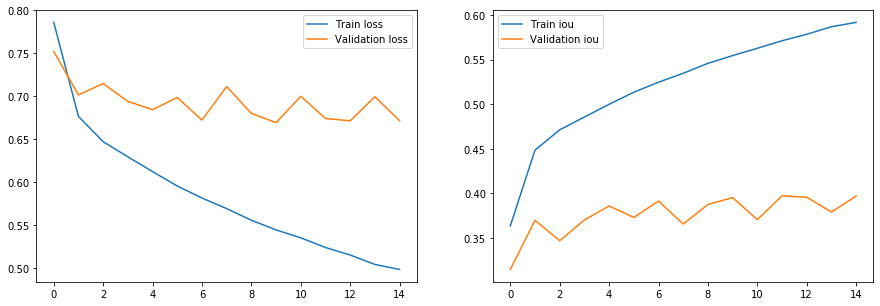

In [23]:
plot_training_history(history)

## Inference and model quality  check

#### Single image

In [61]:
def iou_metric(y_true_in, y_pred_in):
    labels = y_true_in
    y_pred = y_pred_in

    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))

    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union
    return iou

def plot_mask_gt_image(mask, groud_truth, img):
    fig, axs = plt.subplots(1,3, figsize=(20,10))
    axs[0].imshow(mask, cmap="Blues")
    axs[1].imshow(groud_truth, cmap="Blues")
    axs[2].imshow(img)
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    axs[0].title.set_text("predicted")
    axs[1].title.set_text("ground truth")
    axs[2].title.set_text("input image")
    plt.show()
    
def iou_metric_batch(y_true_in, y_pred_in):
    y_pred_in = y_pred_in
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

# to get single image and prediction quality
Xtest, y_test  = test_generator.__getitem__(15)
predicted = model.predict(np.expand_dims(Xtest[0], axis=0)).reshape(1472, 1472)
print('IOU', iou_metric(y_test[0].reshape(1472, 1472), predicted)) 

IOU [[0.62156692]]


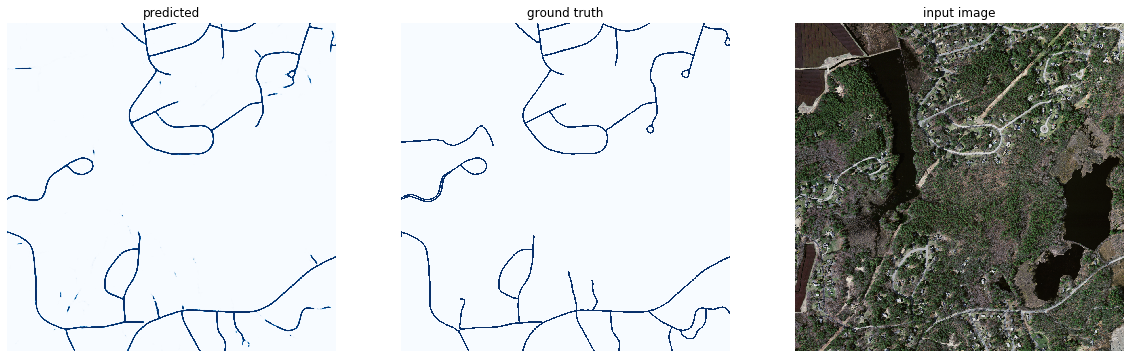

In [62]:
plot_mask_gt_image(predicted, y_test.squeeze(0).squeeze(-1),\
           Xtest.squeeze(0))

## Overall quality

In [63]:
scores = model.evaluate_generator(test_generator)
metrics=[iou_score]
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))  

Loss: 0.67151
mean iou_score: 0.39714
